In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
import os
import cv2
import json

Minimizando a Resolução da imagem e deginindo o tamanho do Lote

In [2]:
base_dir = "./training"

IMAGE_WIDTH  = 256
IMAGE_HEIGHT = 256
BATCH_SIZE = 32

Criando um gerador de dados que aplicará técnicas de data augmentation ao dataset.

In [3]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1. / 255,
  horizontal_flip=True,
  fill_mode='nearest',
  zoom_range=0.3,
  width_shift_range=0.3,
  height_shift_range=0.3,
  rotation_range=30)

Definindo a dimensão das imagens para acomodar imagens RGB (com 3 canais)

In [4]:
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

Criando uma função que retornará um modelo com base na arquitetura DenseNet 201, treinada com os pesos da ImageNet, sem a camada superior, de classificação. É adicionada ao modelo uma camada Fully Connected para a classificação dos 50 labels.

In [5]:
def getModel():
  base_model = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
  )

  base_model.trainable = True
  
  model = tf.keras.Sequential([
      base_model,  # 1
      tf.keras.layers.GlobalAveragePooling2D(),  # 4
      tf.keras.layers.Dense(50, activation='softmax')  # 5
  ])

  model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.0001, momentum=0.9),  # 1
              loss='categorical_crossentropy',  # 2
              metrics=['accuracy'])  # 3

  return model

Utilizando Stratified 5-fold Cross-validation para treinamento/validação do modelo

In [6]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

Carregando nomes dos arquivos de imagem e seus respectivos rótulos

In [7]:
filenames = []
labels    = []

for classname in os.listdir(base_dir):
  class_dir = os.path.join(base_dir, classname)
  if os.path.isdir(class_dir):
    for filename in os.listdir(class_dir):
      if filename.lower().endswith(".jpg"):
        labels.append(classname)
        filenames.append(os.path.join(class_dir, filename))

filenames = np.array(filenames)
labels    = np.array(labels)

Mostrando histograma do dataset utilizado

/Users/kallebe/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


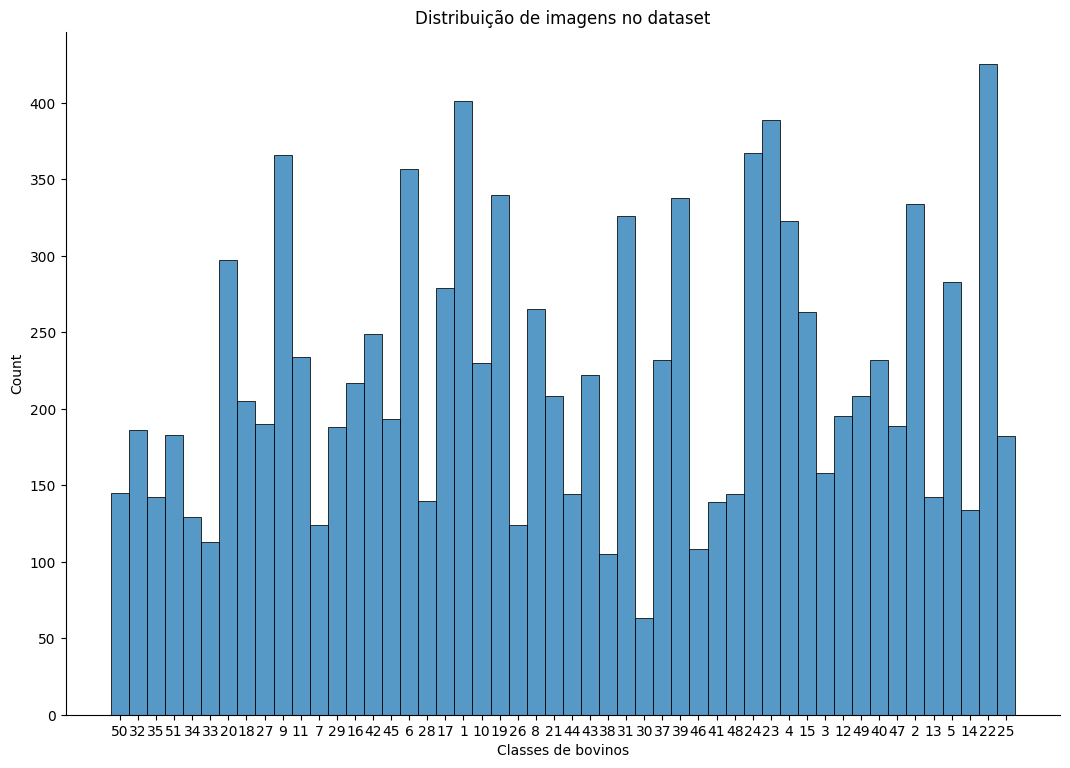

In [8]:
data_df = pd.DataFrame({'data': filenames, 'labels': labels})

ax=sns.displot(data_df, x='labels', bins=50)
ax.set(xlabel='Classes de bovinos', title='Distribuição de imagens no dataset')
ax.figure.set_size_inches(12,8)
plt.show()

Particionando o dataset em conjunto de treinamento e conjunto de teste.

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.1, random_state=42, stratify=labels)

In [11]:
test_set = {
  "data": test_data.tolist(),
  "labels": test_labels.tolist()
}

json_test_set = json.dumps(test_set, indent=2)

with open('test_set.json', 'w') as file:
  file.write(json_test_set)

Definindo as épocas para o treinamento da model

In [10]:
epochs = 20
history_list = []

Escreve divisão do dataset da validação cruzada em um arquivo

In [15]:
folds_training_validation = []

for fold, (train_index, val_index) in enumerate(stratified_kfold.split(train_data, train_labels)):
  fold_resultado = {
    "fold": fold + 1,
    "training": {
      "indexes": train_index.tolist(),
      "data": train_data[train_index].tolist(),
      "labels": train_labels[train_index].tolist()
    },
    "validation": {
      "indexes": val_index.tolist(),
      "data": train_data[val_index].tolist(),
      "labels": train_labels[val_index].tolist()
    }
  }
  folds_training_validation.append(fold_resultado)

# Converter para JSON
json_resultado = json.dumps(folds_training_validation, indent=2)

with open('cross_validation_folds.json', 'w') as file:
  file.write(json_resultado)

Carrega `history_list` a partir de arquivo

In [16]:
# if os.path.exists('history_list.json'):
#   with open('history_list.json', 'r') as file:
#     history_list = json.load(file)

[{'loss': [3.6149373054504395,
   2.533716917037964,
   1.7301069498062134,
   1.238297462463379,
   0.9343259334564209,
   0.7276042103767395,
   0.5818950533866882,
   0.48451730608940125,
   0.4058137536048889,
   0.35070645809173584,
   0.30626681447029114,
   0.26711684465408325,
   0.23761038482189178,
   0.22263765335083008,
   0.19659686088562012,
   0.17717908322811127,
   0.17079631984233856,
   0.15950806438922882,
   0.14012305438518524,
   0.13142137229442596],
  'accuracy': [0.1553313434123993,
   0.5062282085418701,
   0.6804932951927185,
   0.7897359132766724,
   0.851021409034729,
   0.8866467475891113,
   0.9113104343414307,
   0.9311161041259766,
   0.9410812258720398,
   0.9499252438545227,
   0.9559043645858765,
   0.9610114693641663,
   0.9673642516136169,
   0.9663677215576172,
   0.9708520174026489,
   0.9735924005508423,
   0.9713502526283264,
   0.9734678864479065,
   0.9778276085853577,
   0.9784504175186157],
  'val_loss': [3.0188682079315186,
   1.907470941

Define o último fold usado para treinamento/validação:

In [17]:
last_fold = 0

Aplicando o Stratified 10-fold Cross-Validation

In [18]:
folds_training_validation_from_last_fold = folds_training_validation[last_fold:]
for fold in folds_training_validation_from_last_fold:
  print(f"Fold {fold['fold']}/{n_folds}")

  # Separando os dados de treinamento e validação
  train_filenames = fold['training']['data']
  tr_labels = fold['training']['labels']

  val_filenames = fold['validation']['data']
  val_labels = fold['validation']['labels']

  # Criando geradores de dados de treinamento e validação
  train_generator = data_generator.flow_from_dataframe(
    pd.DataFrame({"filename": train_filenames, "class": tr_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
  )

  val_generator = data_generator.flow_from_dataframe(
    pd.DataFrame({"filename": val_filenames, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
  )

  model = getModel()

  # Treinando o modelo
  history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
  history_list.append(history.history)

  json_history = json.dumps(history_list, indent=2)
  with open('history_list.json', 'w') as file:
    file.write(json_history)
  
  last_fold += 1

Fold 3/5
Found 8028 validated image filenames belonging to 50 classes.
Found 2007 validated image filenames belonging to 50 classes.


2023-12-04 22:40:58.538412: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-04 22:40:58.538432: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-04 22:40:58.538439: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-04 22:40:58.538504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 22:40:58.538696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2023-12-04 22:41:07.056217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - ETA: 0s - loss: 3.6368 - accuracy: 0.1570

2023-12-04 22:53:06.166578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 791s 3s/step - loss: 3.6368 - accuracy: 0.1570 - val_loss: 3.0385 - val_accuracy: 0.3513
Epoch 2/20
251/251 [==============================] - 788s 3s/step - loss: 2.5076 - accuracy: 0.5127 - val_loss: 1.8776 - val_accuracy: 0.6308
Epoch 3/20
251/251 [==============================] - 808s 3s/step - loss: 1.7054 - accuracy: 0.6902 - val_loss: 1.2894 - val_accuracy: 0.7559
Epoch 4/20
251/251 [==============================] - 808s 3s/step - loss: 1.2382 - accuracy: 0.7855 - val_loss: 0.9385 - val_accuracy: 0.8401
Epoch 5/20
251/251 [==============================] - 807s 3s/step - loss: 0.9421 - accuracy: 0.8450 - val_loss: 0.7277 - val_accuracy: 0.8824
Epoch 6/20
251/251 [==============================] - 806s 3s/step - loss: 0.7410 - accuracy: 0.8859 - val_loss: 0.5476 - val_accuracy: 0.9188
Epoch 7/20
251/251 [==============================] - 807s 3s/step - loss: 0.6014 - accuracy: 0.9094 - val_loss: 0.4438 - val_accuracy: 0.9302
Epoch 8/20

2023-12-05 03:11:28.391152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - ETA: 0s - loss: 3.6536 - accuracy: 0.1384

2023-12-05 03:24:56.686105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 881s 3s/step - loss: 3.6536 - accuracy: 0.1384 - val_loss: 3.1191 - val_accuracy: 0.3119
Epoch 2/20
251/251 [==============================] - 815s 3s/step - loss: 2.5671 - accuracy: 0.4828 - val_loss: 1.9681 - val_accuracy: 0.6099
Epoch 3/20
251/251 [==============================] - 811s 3s/step - loss: 1.7604 - accuracy: 0.6763 - val_loss: 1.3403 - val_accuracy: 0.7529
Epoch 4/20
251/251 [==============================] - 819s 3s/step - loss: 1.2545 - accuracy: 0.7830 - val_loss: 0.9659 - val_accuracy: 0.8276
Epoch 5/20
251/251 [==============================] - 832s 3s/step - loss: 0.9416 - accuracy: 0.8469 - val_loss: 0.7360 - val_accuracy: 0.8759
Epoch 6/20
251/251 [==============================] - 836s 3s/step - loss: 0.7326 - accuracy: 0.8835 - val_loss: 0.5710 - val_accuracy: 0.9098
Epoch 7/20
251/251 [==============================] - 836s 3s/step - loss: 0.5898 - accuracy: 0.9042 - val_loss: 0.4572 - val_accuracy: 0.9263
Epoch 8/20

2023-12-05 07:45:45.021310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - ETA: 0s - loss: 3.6366 - accuracy: 0.1631

2023-12-05 07:59:20.226977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 901s 3s/step - loss: 3.6366 - accuracy: 0.1631 - val_loss: 3.1053 - val_accuracy: 0.3249
Epoch 2/20
251/251 [==============================] - 869s 3s/step - loss: 2.5291 - accuracy: 0.5187 - val_loss: 1.9380 - val_accuracy: 0.6353
Epoch 3/20
251/251 [==============================] - 883s 4s/step - loss: 1.7052 - accuracy: 0.6977 - val_loss: 1.3314 - val_accuracy: 0.7554
Epoch 4/20
251/251 [==============================] - 845s 3s/step - loss: 1.2236 - accuracy: 0.7902 - val_loss: 0.9735 - val_accuracy: 0.8321
Epoch 5/20
251/251 [==============================] - 880s 4s/step - loss: 0.9238 - accuracy: 0.8558 - val_loss: 0.7253 - val_accuracy: 0.8784
Epoch 6/20
251/251 [==============================] - 871s 3s/step - loss: 0.7214 - accuracy: 0.8895 - val_loss: 0.5764 - val_accuracy: 0.9043
Epoch 7/20
251/251 [==============================] - 834s 3s/step - loss: 0.5798 - accuracy: 0.9153 - val_loss: 0.4614 - val_accuracy: 0.9218
Epoch 8/20

Mostrando as métricas em um gráfico

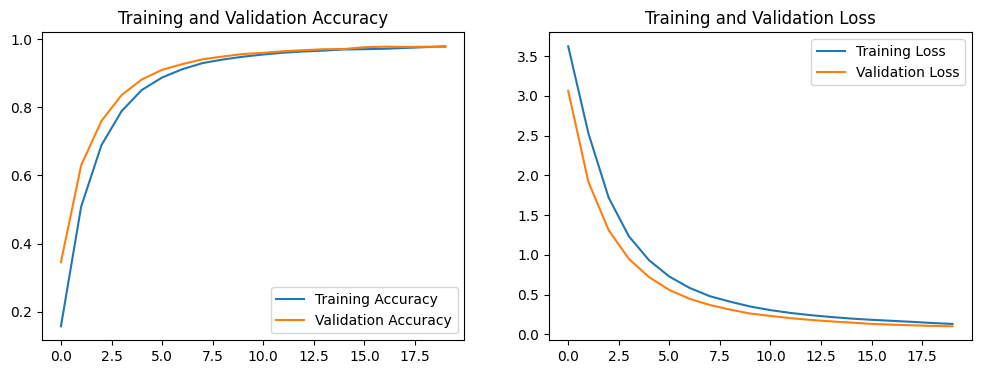

In [19]:
grupo_acc_index       = list(zip(*(d['accuracy'] for d in history_list)))
grupo_loss_index      = list(zip(*(d['val_accuracy'] for d in history_list)))
grupo_val_acc_index   = list(zip(*(d['loss'] for d in history_list)))
grupo_val_loss_index  = list(zip(*(d['val_loss'] for d in history_list)))

acc_values      = [sum(values) / len(values) for values in grupo_acc_index]
val_acc_values  = [sum(values) / len(values) for values in grupo_loss_index]
loss_values     = [sum(values) / len(values) for values in grupo_val_acc_index]
val_loss_values = [sum(values) / len(values) for values in grupo_val_loss_index]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Carregando e redimensionando as imagens do conjunto de teste

In [44]:
def load_and_resize_images(file_paths):
  images = []
  for file_path in file_paths:
    img = cv2.imread(file_path)
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = img / 255.0
    images.append(img)
  return np.array(images)

In [15]:
# model = getModel()
# model.load_weights('./checkpoints/pesos-faceboi')

Validando modelo com conjunto de teste

In [47]:
test_dataset = load_and_resize_images(test_data)

y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

35/35 [==============================] - 25s 725ms/step


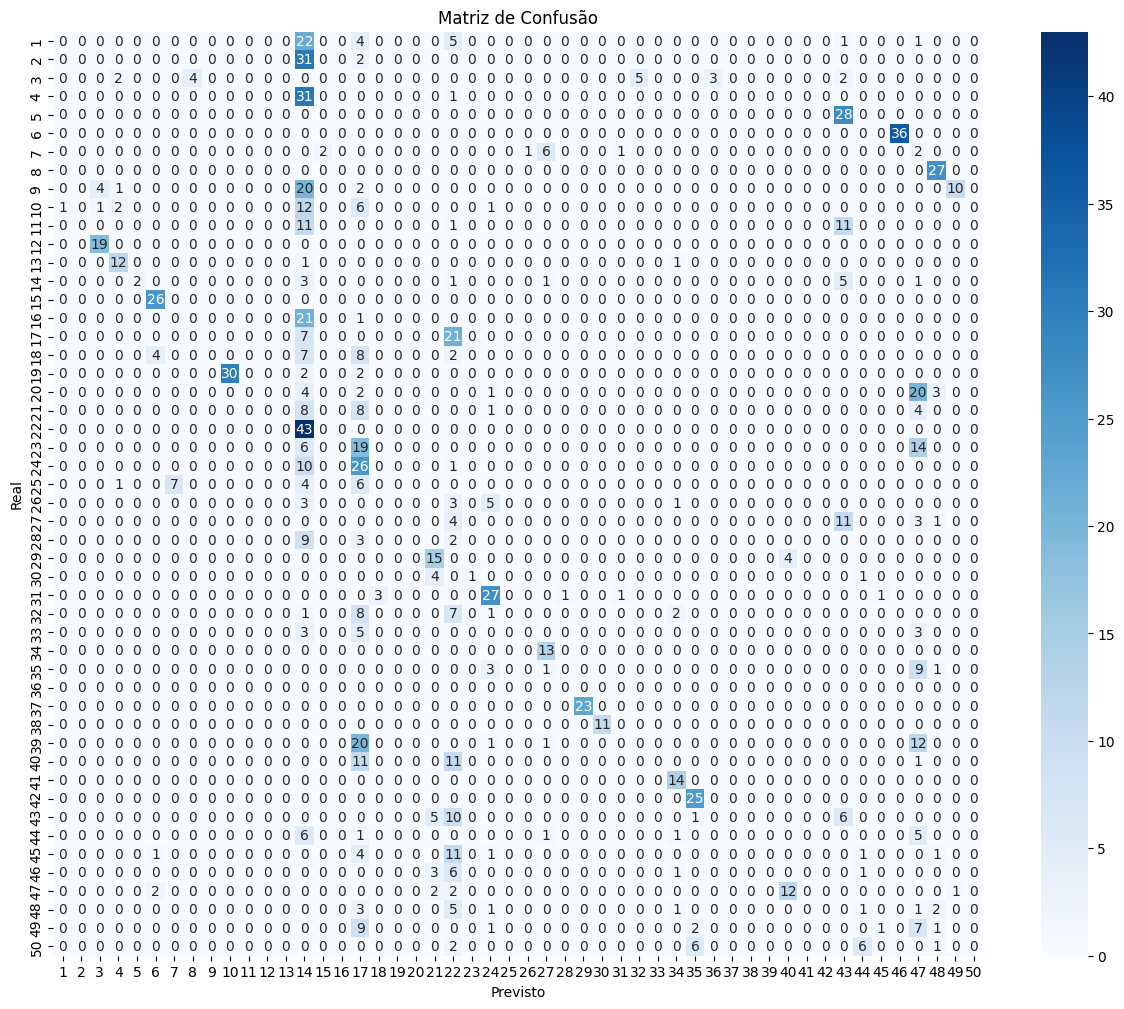

[ 4 35 14 ... 34 22 29]
['25' '50' '32' ... '41' '17' '37']


In [49]:
y_test = [int(x) for x in test_labels]
conf_mat = confusion_matrix(y_test, y_pred, labels=range(1, 51))

plt.figure(figsize=(15, 12))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 51), yticklabels=range(1, 51))
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()